In [3]:
# 1. Установка драйвера
!pip install pymongo[srv] matplotlib

Username **techmastermcu_db_user**

Password **gDttTUo3Exu1LpxH**

https://cloud.mongodb.com/



In [4]:
import matplotlib.pyplot as plt
from pymongo import MongoClient, ASCENDING, DESCENDING
from pymongo.errors import DuplicateKeyError
from datetime import datetime, timedelta
from typing import List, Dict, Optional
from bson import ObjectId

✅ Подключение к MongoDB успешно.
📦 Каталог заполнен.
💰 Заказы обработаны.

📊 Формирование отчета...


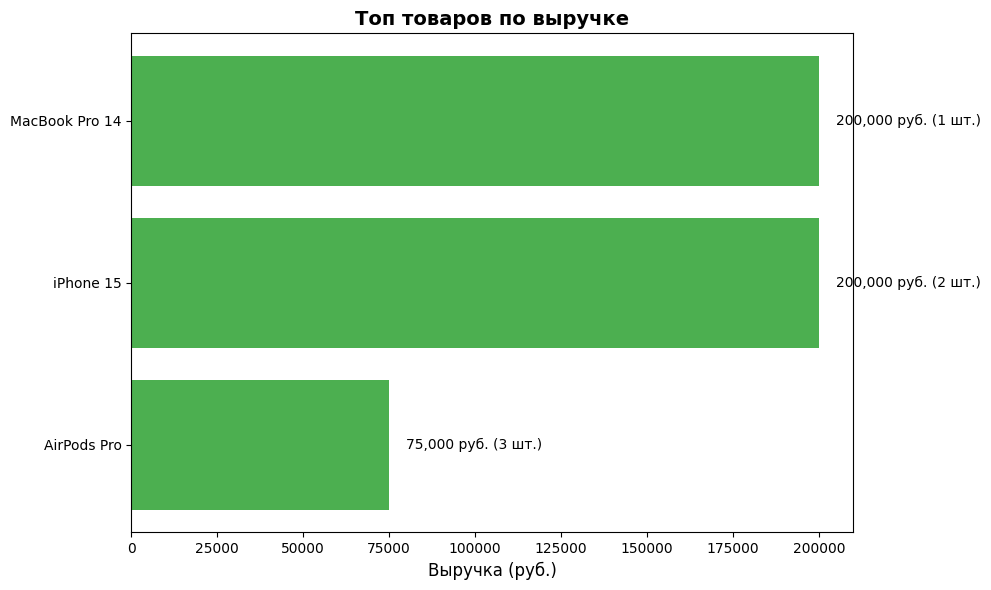

In [ ]:
# Установка необходимых библиотек
# !pip install pymongo[srv] matplotlib

import matplotlib.pyplot as plt
from pymongo import MongoClient, ASCENDING, DESCENDING
from pymongo.errors import DuplicateKeyError
from datetime import datetime, timedelta, timezone
from typing import List, Dict, Optional
from bson import ObjectId

# ==========================================
# 1. КОНФИГУРАЦИЯ ПОДКЛЮЧЕНИЯ
# ==========================================
# Вставьте сюда ваши данные пользователя MongoDB Atlas:
DB_USER = "__________________"
DB_PASSWORD = "_____________"
DB_CLUSTER = "_______________"

# Формирование строки подключения (Connection String)
MONGO_URI = f"mongodb+srv://{DB_USER}:{DB_PASSWORD}@{DB_CLUSTER}/?retryWrites=true&w=majority"

class OnlineStore:
    """
    Класс для управления интернет-магазином на MongoDB.
    Реализует основные CRUD-операции, транзакции и аналитику.
    """

    def __init__(self, connection_string: str):
        self.client = MongoClient(connection_string)
        self.db = self.client['online_store']

        # Очистка базы перед тестом (для воспроизводимости результатов)
        self.db.products.drop()
        self.db.orders.drop()

        self._ensure_indexes()

    def _ensure_indexes(self):
        """Создание индексов для оптимизации запросов."""
        # Ускорение фильтрации каталога
        self.db.products.create_index([
            ('category', ASCENDING),
            ('price', ASCENDING)
        ])
        # Контроль уникальности артикула
        self.db.products.create_index('sku', unique=True)
        # История заказов
        self.db.orders.create_index([
            ('customer_id', ASCENDING),
            ('created_at', DESCENDING)
        ])

    def add_product(self, product: Dict) -> str:
        """Добавление товара."""
        # Использование timezone.utc для корректной работы со временем
        product['created_at'] = datetime.now(timezone.utc)
        product['stock'] = product.get('stock', 0)
        try:
            result = self.db.products.insert_one(product)
            return str(result.inserted_id)
        except DuplicateKeyError:
            raise ValueError(f"Товар с SKU '{product['sku']}' уже существует")

    def search_products(self, category: str = None, min_price: float = 0) -> List[Dict]:
        """Поиск товаров."""
        query = {'stock': {'$gt': 0}}
        if category:
            query['category'] = category
        if min_price:
            query['price'] = {'$gte': min_price}

        return list(self.db.products.find(query, {'_id': 0, 'name': 1, 'price': 1}))

    def create_order(self, customer_id: str, items: List[Dict]) -> str:
        """
        Создание заказа в транзакции.
        Атомарно списывает остатки и создает документ заказа.
        """
        with self.client.start_session() as session:
            with session.start_transaction():
                order_items = []
                total = 0

                for item in items:
                    # Атомарное обновление остатка
                    result = self.db.products.update_one(
                        {
                            '_id': ObjectId(item['product_id']),
                            'stock': {'$gte': item['quantity']}
                        },
                        {'$inc': {'stock': -item['quantity']}},
                        session=session
                    )

                    if result.modified_count == 0:
                        raise ValueError(f"Недостаточно товара ID: {item['product_id']}")

                    # Получение актуальной цены
                    product = self.db.products.find_one(
                        {'_id': ObjectId(item['product_id'])},
                        session=session
                    )

                    order_items.append({
                        'name': product['name'],
                        'price': product['price'],
                        'quantity': item['quantity']
                    })
                    total += product['price'] * item['quantity']

                order = {
                    'customer_id': customer_id,
                    'items': order_items,
                    'total': total,
                    'created_at': datetime.now(timezone.utc)
                }
                res = self.db.orders.insert_one(order, session=session)
                return str(res.inserted_id)

    def visualize_sales(self, days: int = 30):
        """Построение аналитического отчета (Aggregation Framework + Matplotlib)."""
        pipeline = [
            # Фильтрация по дате (последние N дней)
            {'$match': {
                'created_at': {'$gte': datetime.now(timezone.utc) - timedelta(days=days)}
            }},
            {'$unwind': '$items'},
            {'$group': {
                '_id': '$items.name',
                'revenue': {'$sum': {'$multiply': ['$items.price', '$items.quantity']}},
                'count': {'$sum': '$items.quantity'}
            }},
            {'$sort': {'revenue': -1}}
        ]

        data = list(self.db.orders.aggregate(pipeline))

        if not data:
            print("Нет продаж для анализа.")
            return

        # Подготовка данных для графика
        names = [item['_id'] for item in data]
        revenues = [item['revenue'] for item in data]
        counts = [item['count'] for item in data]

        # Отрисовка
        fig, ax = plt.subplots(figsize=(10, 6))
        bars = ax.barh(names, revenues, color='#4CAF50')

        # Оформление
        ax.set_xlabel('Выручка (руб.)', fontsize=12)
        ax.set_title('Топ товаров по выручке', fontsize=14, fontweight='bold')
        ax.invert_yaxis()  # Лидеры сверху

        # Добавление подписей значений
        for i, bar in enumerate(bars):
            width = bar.get_width()
            label = f"{int(width):,} руб. ({counts[i]} шт.)"
            ax.text(width + 5000, bar.get_y() + bar.get_height()/2, label,
                    va='center', fontsize=10, color='black')

        plt.tight_layout()
        plt.show()

# ==========================================
# ТОЧКА ВХОДА (ТЕСТИРОВАНИЕ)
# ==========================================
if __name__ == '__main__':
    try:
        store = OnlineStore(MONGO_URI)
        print("✅ Подключение к MongoDB успешно.")

        # 1. Наполнение каталога
        p1 = store.add_product({'name': 'MacBook Pro 14', 'sku': 'MBP-14', 'price': 200000, 'category': 'laptop', 'stock': 10})
        p2 = store.add_product({'name': 'iPhone 15', 'sku': 'IPH-15', 'price': 100000, 'category': 'phone', 'stock': 20})
        p3 = store.add_product({'name': 'AirPods Pro', 'sku': 'AIR-PRO', 'price': 25000, 'category': 'audio', 'stock': 50})
        print("📦 Каталог заполнен.")

        # 2. Симуляция заказов
        # Клиент 1: Купил ноутбук и наушники
        store.create_order('user_1', [
            {'product_id': p1, 'quantity': 1},
            {'product_id': p3, 'quantity': 1}
        ])

        # Клиент 2: Купил 2 айфона
        store.create_order('user_2', [
            {'product_id': p2, 'quantity': 2}
        ])

        # Клиент 3: Купил наушники
        store.create_order('user_3', [
            {'product_id': p3, 'quantity': 2}
        ])
        print("💰 Заказы обработаны.")

        # 3. Аналитика
        print("\n📊 Формирование отчета...")
        store.visualize_sales()

    except Exception as e:
        print(f"❌ Ошибка: {e}")